# Chart Library Notebook

This notebook will begin the basis for production level chart library using the agmktdb.

In [8]:
import os

# Data science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database
from sqlalchemy import create_engine
import psycopg2
import agmkt_pkg.nass as nass
import agmkt_pkg.ams as ams
import agmkt_pkg.env_vars as env_vars
import agmkt_pkg.utils as utils

# style sheets
# plt.style.use('fivethirtyeight')
plt.style.use('./style_sheets/agmktstyle.mplstyle')

print('Libraries imported!!')

Libraries imported!!


# Create SELECT statement to pull raw data

In [9]:
# create sql connection
user = env_vars.mktdb_user()
password = env_vars.mktdb_passwd()
server = env_vars.mktdb_server()


connection_string = f'postgresql://{user}:{password}@{server}/mktdb'
eng = create_engine(connection_string)
conn = eng.connect()

In [10]:
stmt_dict0 = {'commodity':'Corn', 'class':'Yellow', 'grade':'US #2', 
             'market_location_state':'VA', 'trade_loc':'Norfolk Terminal Area', 'delivery_point':'Terminal Elevators', 
             'freight':'Delivered', 'trans_mode':'Truck', 'current':'Yes'}

df0 = ams.df_grain_time_series_chart(stmt_dict0, conn, table='mars_grain_bids')

print(df0.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 650 entries, 2021-04-01 to 2025-01-17
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_begin_date        650 non-null    datetime64[ns]
 1   report_end_date          650 non-null    datetime64[ns]
 2   published_date           650 non-null    datetime64[ns]
 3   office_name              650 non-null    object        
 4   office_city              650 non-null    object        
 5   office_state             650 non-null    object        
 6   market_type              650 non-null    object        
 7   market_location_name     650 non-null    object        
 8   market_location_city     0 non-null      object        
 9   market_location_state    650 non-null    object        
 10  slug_id                  650 non-null    int64         
 11  slug_name                650 non-null    object        
 12  report_title     

In [11]:
stmt_dict = {'COMMODITY_DESC':'CORN', 'PRODN_PRACTICE_DESC':'ALL PRODUCTION PRACTICES', 
             'UTIL_PRACTICE_DESC':'GRAIN', 
            # 'CLASS_DESC':'OIL TYPE',
             'STATISTICCAT_DESC':'AREA HARVESTED', 'UNIT_DESC':'ACRES', 'AGG_LEVEL_DESC':'NATIONAL', 'REFERENCE_PERIOD_DESC':'YEAR'}

df = nass.df_time_series_chart(stmt_dict=stmt_dict, db_connect=conn)


In [12]:
keys = ['COMMODITY_DESC', 'CLASS_DESC', 'STATISTICCAT_DESC', 'UNIT_DESC', 'STATE_ALPHA']

filename = ''

for key in keys:
    if stmt_dict.get(key) == None:
        next
    else:
        filename += stmt_dict.get(key).lower() + '_'

filename = filename[:-1] + '.png'


# Manipulate data for data visualization

In [13]:
# print(df.info())

# df_trim = utils.keep_cols(df, default_cols=['SHORT_DESC'])

# print(df_trim.info())


# Create Visualziation and save image to folder

In [14]:
# scale_dict = {
#     'Unit':{'value':1, 'label':''},
#     'Thousand':{'value':1e3, 'label':'Thousand'},
#     'Million':{'value':1e6, 'label':'Million'},
#     'Billion':{'value':1e9, 'label':'Billion'},
# }

# df_viz = df[df['date'].dt.year >= df['date'].dt.year.max() - 50]

# str_commodity = stmt_dict['COMMODITY_DESC'].title()
# str_statistic = stmt_dict['STATISTICCAT_DESC'].title()
# str_unit = stmt_dict['UNIT_DESC'].title()

# plt.subplot()
# scale = 'Unit'
# scale_value = scale_dict[scale]['value']
# scale_label = scale_dict[scale]['label']
# sns.lineplot(data=df_viz, x='date', y=df['VALUE']/scale_value)
# sns.scatterplot(data=df_viz, x='date', y=df['VALUE']/scale_value)
# plt.title(f'U.S. {str_commodity} {str_statistic}')
# plt.ylabel(f'{scale_label} {str_unit}')
# plt.xlabel('Crop Year')
# plt.show()

In [15]:
nass.time_series_chart(df, stmt_dict, './docs', years = 30, scale='Million')

Matplot chart saved to ./docs/corn_grain_areaharvested_acres_year.png


<Figure size 640x480 with 0 Axes>

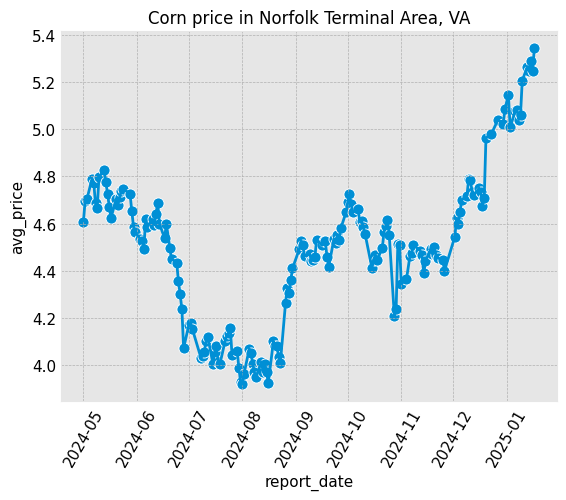

In [16]:
start_date = '2024-05-01'

df_viz = df0[start_date:]

str_commodity = stmt_dict0['commodity'].title()
str_location = stmt_dict0['trade_loc'].title()
str_state = stmt_dict0['market_location_state'].upper()

plt.subplot()
scale = 'Unit'
# scale_value = scale_dict[scale]['value']
# scale_label = scale_dict[scale]['label']
sns.lineplot(data=df_viz, x=df_viz.index, y='avg_price')
sns.scatterplot(data=df_viz, x=df_viz.index, y='avg_price')
plt.title(f'{str_commodity} price in {str_location}, {str_state}')
plt.xticks(rotation=60)
# plt.ylabel(f'{scale_label} {str_unit}')
# plt.xlabel('Crop Year')
plt.show()

## Inventory Charts

In [17]:
# Dataframe

stmt = {'COMMODITY_DESC':'CORN', 'PRODN_PRACTICE_DESC':'ALL PRODUCTION PRACTICES', 
        'UTIL_PRACTICE_DESC':['ON FARM, GRAIN', 'OFF FARM, GRAIN'], 
        'STATISTICCAT_DESC':'STOCKS', 'UNIT_DESC':'BU', 'AGG_LEVEL_DESC':'NATIONAL', 'FREQ_DESC':'POINT IN TIME'}

df = nass.df_time_series_chart(stmt, conn, 'nass_crops_fmt')

In [18]:
filter_string = ''

for key, value in stmt.items():
    try:
        if type(stmt.get(key)) == str:
            filter_string += f"""AND "{key}" IN ('{value}') """
        elif type(stmt.get(key)) == list:
            list_str = ""
            for v in value:
                list_str += f"""'{v}', """
            list_str = list_str[:-2] + "'"
            filter_string += f"""AND "{key}" IN ({list_str}) """
        else:
            TypeError('Type not found for filter string')
    except:
        pass
    
print(filter_string)

AND "COMMODITY_DESC" IN ('CORN') AND "PRODN_PRACTICE_DESC" IN ('ALL PRODUCTION PRACTICES') AND "UTIL_PRACTICE_DESC" IN ('ON FARM, GRAIN', 'OFF FARM, GRAIN'') AND "STATISTICCAT_DESC" IN ('STOCKS') AND "UNIT_DESC" IN ('BU') AND "AGG_LEVEL_DESC" IN ('NATIONAL') AND "FREQ_DESC" IN ('POINT IN TIME') 


In [19]:
display(df.tail())

,SOURCE_DESC,SECTOR_DESC,GROUP_DESC,COMMODITY_DESC,CLASS_DESC,PRODN_PRACTICE_DESC,UTIL_PRACTICE_DESC,STATISTICCAT_DESC,UNIT_DESC,SHORT_DESC,...,YEAR,FREQ_DESC,BEGIN_CODE,END_CODE,REFERENCE_PERIOD_DESC,WEEK_ENDING,LOAD_TIME,VALUE,CV_%,date
716,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,"OFF FARM, GRAIN",STOCKS,BU,"CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU",...,2021,POINT IN TIME,3,3,FIRST OF MAR,None,2024-01-09 15:00:00,3.770278e+09,None,2021-01-01
717,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,"OFF FARM, GRAIN",STOCKS,BU,"CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU",...,2022,POINT IN TIME,12,12,FIRST OF DEC,None,2024-01-09 15:00:00,4.073207e+09,None,2022-01-01
718,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,"OFF FARM, GRAIN",STOCKS,BU,"CORN, OFF FARM, GRAIN - STOCKS, MEASURED IN BU",...,2024,POINT IN TIME,12,12,FIRST OF DEC,None,2025-01-10 12:00:00,4.411194e+09,None,2024-01-01
719,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,"ON FARM, GRAIN",STOCKS,BU,"CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU",...,2022,POINT IN TIME,12,12,FIRST OF DEC,None,2024-01-09 15:00:00,6.740000e+09,None,2022-01-01
720,SURVEY,CROPS,FIELD CROPS,CORN,ALL CLASSES,ALL PRODUCTION PRACTICES,"ON FARM, GRAIN",STOCKS,BU,"CORN, ON FARM, GRAIN - STOCKS, MEASURED IN BU",...,2024,POINT IN TIME,12,12,FIRST OF DEC,None,2025-01-10 12:00:00,7.663000e+09,None,2024-01-01


In [64]:
df_viz = df[(df['date'].dt.year > 2010) & df['date'].dt.month > 11]
df_viz = df_viz.pivot_table(index='date', columns='UTIL_PRACTICE_DESC', values='VALUE')
df_viz.columns = ['OFF FARM', 'ON FARM']
df_viz.head()

# ax, fig = plt.subplots(1, 4)
# g = sns.FacetGrid(df_viz, col = 'BEGIN_CODE')
# g = (g.map(sns.barplot, 'YEAR', 'VALUE', color='UTIL_PRACTICE_DESC', ci=None).add_legend())
# ax, fig = plt.subplots()
# sns.catplot(df_viz, kind='bar', x='YEAR', y='VALUE', hue='UTIL_PRACTICE_DESC', col='BEGIN_CODE', col_wrap=2)
# plt.bar(x=df_viz['date'].dt.month, y=df_viz['ON FARM'])
df_viz.plot(kind='bar', stacked=True, color=['blue', 'green'])
plt.show()


ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements